Hi everyone.
This is my first kernel in kaggle and thought of writing about **anomaly detection** and its **visualization**. First I would like to thank **Sudalai Rajkumar** for his kernels which are great inspiration to me.

A sudden spike or dip in a metric is an **anomalous** behavior and both the cases needs attention. Detection of anomaly can be solved by supervised learning algorithms if we have information on anomalous behavior before modeling, but initially without feedback its difficult to identify that points. So we model this as an **unsupervised** problem using algorithms like **Isolation Forest**,One class SVM and LSTM. Here we are identifying anomalies using isolation forest.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings  
warnings.filterwarnings('ignore')
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['metric_data.csv']


The data here is for a **use case**(eg revenue,traffic etc ) is at a day level with 12 metrics.We have to identify first if there is an anomaly at an use case level.Then for better actionalbility we **drill down** to individual metrics and identify anomalies in them. 


In [2]:

df=pd.read_csv("../input/metric_data.csv")
df.head()

,load_date,metric_name,actuals
0,20181013,metric_1,2672516.00
1,20181013,metric_6,44764.54
2,20181106,metric_11,1987129.00
3,20181106,metric_10,28973769.00
4,20181013,metric_12,8721082.00


Now I do a **pivot** on the dataframe to create a dataframe with all metrics at a **date level.**

In [3]:
metrics_df=pd.pivot_table(df,values='actuals',index='load_date',columns='metric_name')
metrics_df.head()

metric_name,metric_1,metric_10,metric_11,metric_12,metric_2,metric_3,metric_4,metric_5,metric_6,metric_7,metric_8,metric_9
load_date,,,,,,,,,,,,
20181011,2577175.0,76039967.0,4149813.0,8987742.0,3.678389e+07,1.157879e+08,31105.01,3.014107e+07,56426.80,6509043.03,1.040538e+08,4.420061e+07
20181012,2442547.0,70923685.0,3718773.0,8199982.0,3.426129e+07,1.065062e+08,18028.98,2.704617e+07,54303.28,5714708.02,9.539968e+07,4.106401e+07
20181013,2672516.0,72518603.0,3886795.0,8721082.0,3.298709e+07,1.021233e+08,10355.88,2.757672e+07,44764.54,5778445.03,9.418868e+07,3.997818e+07
20181014,2979667.0,80217672.0,4502964.0,10054732.0,5.324695e+07,1.658637e+08,33756.40,4.456647e+07,69693.39,9595411.37,1.528533e+08,6.603252e+07
20181015,2422576.0,61723489.0,2913531.0,6582262.0,1.742143e+07,5.460811e+07,8737.36,1.747807e+07,29590.28,3523686.58,5.731582e+07,2.406826e+07


Level the multi-index pivot dataframe and treat na with 0

In [4]:
metrics_df.reset_index(inplace=True)
metrics_df.fillna(0,inplace=True)
metrics_df.head()

metric_name,load_date,metric_1,metric_10,metric_11,metric_12,metric_2,metric_3,metric_4,metric_5,metric_6,metric_7,metric_8,metric_9
0,20181011,2577175.0,76039967.0,4149813.0,8987742.0,3.678389e+07,1.157879e+08,31105.01,3.014107e+07,56426.80,6509043.03,1.040538e+08,4.420061e+07
1,20181012,2442547.0,70923685.0,3718773.0,8199982.0,3.426129e+07,1.065062e+08,18028.98,2.704617e+07,54303.28,5714708.02,9.539968e+07,4.106401e+07
2,20181013,2672516.0,72518603.0,3886795.0,8721082.0,3.298709e+07,1.021233e+08,10355.88,2.757672e+07,44764.54,5778445.03,9.418868e+07,3.997818e+07
3,20181014,2979667.0,80217672.0,4502964.0,10054732.0,5.324695e+07,1.658637e+08,33756.40,4.456647e+07,69693.39,9595411.37,1.528533e+08,6.603252e+07
4,20181015,2422576.0,61723489.0,2913531.0,6582262.0,1.742143e+07,5.460811e+07,8737.36,1.747807e+07,29590.28,3523686.58,5.731582e+07,2.406826e+07


Define **isolation forest** and specify parameters. 

Isolation forest tries to **separate each point** in the data.In case of 2D it randomly creates a line and tries to single out a point. Here an **anomalous point could be separated in few steps while normal points which are closer could take significantly more steps to be segregated.**

I am not going deep into each parameter.**Contamination** is an important parameter here and I have not specified the any value for it as its unsupervised and we dont have information on percentage of outliers.You can also specify it by trial and error on validating its results with outliers in 2D plot or if your data is supervised use that information to specify it. It stands for **percentage of outlier points** in the data.


I am using **sklearn's Isolation Forest** here as it is a small dataset with few months of data, while recently **h2o's **isolation forest is also available which is more scalable on high volume datasets would be worth exploring.

*More details of the algorithm can be found here : https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf

More details on H2O Isolation forest : https://github.com/h2oai/h2o-tutorials/tree/master/tutorials/isolation-forest
        *

In [5]:
metrics_df.columns


Index(['load_date', 'metric_1', 'metric_10', 'metric_11', 'metric_12',
       'metric_2', 'metric_3', 'metric_4', 'metric_5', 'metric_6', 'metric_7',
       'metric_8', 'metric_9'],
      dtype='object', name='metric_name')

In [6]:
#specify the 12 metrics column names to be modelled
to_model_columns=metrics_df.columns[1:13]

In [7]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(metrics_df[to_model_columns])

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
        random_state=42, verbose=0)

In [8]:
pred = clf.predict(metrics_df[to_model_columns])
metrics_df['anomaly']=pred
outliers=metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(metrics_df['anomaly'].value_counts())


 1    109
-1     12
Name: anomaly, dtype: int64


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Now here we have 12 metrics on which we have classified anomalies based on isolation forest.We will try to **visualize** the results and check if the classification makes sense.

Normalize and fit the metrics to a **PCA** to reduce the number of dimensions and then plot them in 3D highlighting the anomalies.

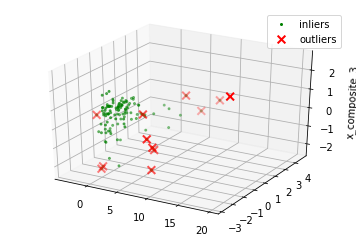

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(metrics_df[to_model_columns])
X_reduce = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

Now as we see the 3D point the anomaly points are mostly wide from the cluster of normal points,but a 2D point will help us to even judge better.
Lets try plotting the same fed to a PCA reduced to 2 dimensions.

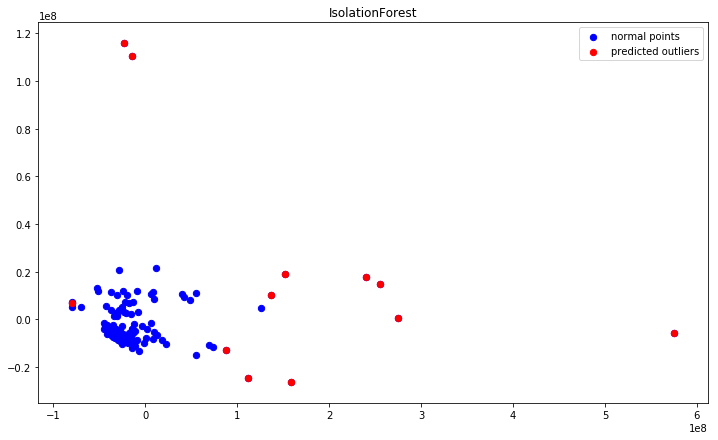

In [10]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(metrics_df[to_model_columns])


res=pd.DataFrame(pca.transform(metrics_df[to_model_columns]))

Z = np.array(res)
figsize=(12, 7)
plt.figure(figsize=figsize)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(res[0], res[1], c='blue',
                 s=40,label="normal points")

b1 = plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',
                 s=40,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()


So a 2D plot gives us a clear picture that the algorithm classifies anomalies points in the use case rightly. 

Anomalies are highlighted as **red edges** and normal points are indicated with **green points** in the plot. 

Here the **contamination** parameter plays a great factor.
Our idea here is to capture all the anomalous point in the system. 
So its **better to identify few points which might be normal as anomalous(false positives) ,but not to miss out catching an anomaly(true negative)**.(So i have specified 12% as contamintion which varies based on use case)


In [11]:
#Installing specific version of plotly to avoid Invalid property for color error in recent version which needs change in layout
!pip install plotly==2.7.0

    100% |████████████████████████████████| 25.0MB 1.7MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/0c/3e/07/4848195c61f659184ca41d5a614845a018ab2d2f2a705b9998
Successfully built plotly
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 2.7.0 which is incompatible.
  Found existing installation: plotly 3.6.1
    Uninstalling plotly-3.6.1:
      Successfully uninstalled plotly-3.6.1


Now we have figured the **anomalous behaviour** at a use case level.But to be actionable on the **anomaly** its important to identify and provide information on **which metrics are anomalous in it individually.**

The anomalies identified by the algorithm should make sense when viewed **visually**(sudden dip/peaks) by the business user to action upon it. So creating a** good visualization is equally important in this process**.

This function creates **actuals plot on a time series with anomaly points highlighted on it**. Also a table which provides actual data, the change and conditional formatting based on anomalies.

In [12]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
def plot_anomaly(df,metric_name):
    df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y%m%d")
    dates = df.load_date
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "red"}
    
    #Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
        domain=dict(x=[0, 1],
                    y=[0, 0.3]),
        columnwidth=[1, 2],
        # columnorder=[0, 1, 2,],
        header=dict(height=20,
                    values=[['<b>Date</b>'], ['<b>Actual Values </b>'], ['<b>% Change </b>'],
                            ],
                    font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                    fill=dict(color='#d562be')),
        cells=dict(values=[df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'percentage_change']],
                   line=dict(color='#506784'),
                   align=['center'] * 5,
                   font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                   # format = [None] + [",.4f"] + [',.4f'],
                   # suffix=[None] * 4,
                   suffix=[None] + [''] + [''] + ['%'] + [''],
                   height=27,
                   fill=dict(color=[test_df['anomaly_class'].map(color_map)],#map based on anomaly level from dictionary
                   )
                   ))
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                         x=dates,
                         y=df['actuals'],
                         xaxis='x1', yaxis='y1',
                         mode='line',
                         marker=dict(size=12,
                                     line=dict(width=1),
                                     color="blue"))

    #Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))


    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))

    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))

    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)

    iplot(fig)
    pyplot.show()
    #return res

A helper function to find percentage change,classify anomaly based on **severity**.

The **predict function** classifies the data as anomalies based on the results from **decision function** on crossing a threshold.
Say if the business needs to find the next level of anomalies which might have an impact,this could be used to identify those points.

The top 12 quantile are identified anomalies(high severity),based on decision function here we identify the 12-24 quantile points and classify them as low severity anomalies.


In [13]:
def classify_anomalies(df,metric_name):
    df['metric_name']=metric_name
    df = df.sort_values(by='load_date', ascending=False)
    #Shift actuals by one timestamp to find the percentage chage between current and previous data point
    df['shift'] = df['actuals'].shift(-1)
    df['percentage_change'] = ((df['actuals'] - df['shift']) / df['actuals']) * 100
    #Categorise anomalies as 0-no anomaly, 1- low anomaly , 2 - high anomaly
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (df['score'] <= medium_percentile)] = 1
    return df


Identify anomalies for individual metrics and plot the results. 

**X axis -  date 
Y axis - Actual values and anomaly points.**

Actual values of metrics are indicated in the **blue line** and anomaly points are highlighted as **red points**.

In the table, background **red** indicates high anomalies and **yellow** indicates low anomalies.

In [14]:
import warnings  
warnings.filterwarnings('ignore')
for i in range(1,len(metrics_df.columns)-1):
    clf.fit(metrics_df.iloc[:,i:i+1])
    pred = clf.predict(metrics_df.iloc[:,i:i+1])
    test_df=pd.DataFrame()
    test_df['load_date']=metrics_df['load_date']
    #Find decision function to find the score and classify anomalies
    test_df['score']=clf.decision_function(metrics_df.iloc[:,i:i+1])
    test_df['actuals']=metrics_df.iloc[:,i:i+1]
    test_df['anomaly']=pred
    #Get the indexes of outliers in order to compare the metrics with use case anomalies if required
    outliers=test_df.loc[test_df['anomaly']==-1]
    outlier_index=list(outliers.index)
    test_df=classify_anomalies(test_df,metrics_df.columns[i])
    plot_anomaly(test_df,metrics_df.columns[i])

Yes, from the plots we are able to capture the **sudden spikes, dips in the metrics and projects them**. 

Also the **conditional formatted table** gives us insights on cases like data not present(value is zero) captured as high anomaly which could be a **potential result of broken pipeline in data processing** which needs fixing along with highlighting high and low level anomalies.

How to use this?

If the **current timestamp is anomalous** for a use case **drill down** to metrics figure out the set of metrics which have high anomalies in the timestamp to perform RCA on it.

Also a **feedback** from the business user can be updated back in the data which would help in turning this to a supervised/semi supervised learning problem and compare their results.

A enhancement here would be to **combine anomalous behaviour which occur continously** . For eg. big sale days which would result in spike in metrics for few days could be shown as a single behaviour.




Special thanks to my manager **Shrinivas Ron**, **Goldee** and my teammates **Sudarson, Adam**    in Myntra for their help in anomaly detection.

Next I will write more on **forecasting time series and identifying anomalies**,methods of doing it along with their pros and cons. 

**Thank you.Your suggestions and comments are welcome.**

**Please do share the kernal if you find it useful and interesting.**